# PSF Model Basics

Here we will cover some of the main ways to use PSF and point source models in AstroPhot. You will learn how to make a model with a PSF blurring kernel as well as define point sources in images.

In [1]:
%load_ext autoreload
%autoreload 2

import astrophot as ap
import numpy as np
import torch
import matplotlib.pyplot as plt
%matplotlib inline

## PSF Images

A `PSF_Image` is an AstroPhot object which stores the data for a PSF. It records the pixel values for the PSF as well as meta-data like the pixelscale at which it was taken. The point source function (PSF) is a description of how light is distributed into pixels when the light source is a delta function. In Astronomy we are blessed/cursed with many delta function like sources in our images and so PSF modelling is a major component of astronomical image analysis. Here are som points to keep in mind about a PSF.

- PSF images are always odd in shape (e.g. 25x25 pixels, not 24x24 pixels), at the center pixel, in the center of that pixel is where the delta function point source is located by definition
- In AstroPhot, the coordinates of the center of the center pixel in a `PSF_Image` are always (0,0). 
- The light in each pixel of a PSF image is already integrated. That is to say, the flux value for a pixel does not represent some model evaluated at the center of the pixel, it instead represents an integral over the whole area of the pixel

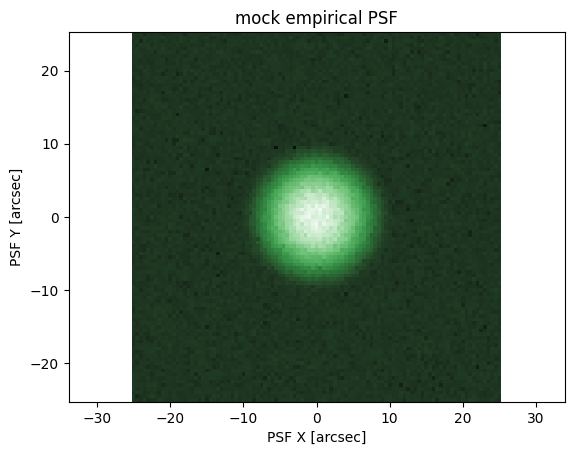

In [8]:
# An example fake "empirical PSF"
np.random.seed(124)
psf = ap.utils.initialize.gaussian_psf(2., 101, 0.5)
psf += 1e-7
psf += np.random.normal(scale = psf / 4)
psf[psf < 0] = ap.utils.initialize.gaussian_psf(2., 101, 0.5)[psf < 0]

psf_target = ap.image.PSF_Image(
    data=psf,
    pixelscale=0.5,
)

# To ensure the PSF has a normalized flux of 1, we call
psf_target.normalize()

fig, ax = plt.subplots()
ap.plots.psf_image(fig, ax, psf_target)
ax.set_title("mock empirical PSF")
plt.show()

# Dummy target for sampling purposes
target = ap.image.Target_Image(data = np.zeros((300,300)),pixelscale = 0.5,psf = psf_target)

## Point Sources (star, super nova, distant galaxy, quasar, asteroid, etc.)

One of the most common astronomical sources is a point source. This is a source of light which is so small that it is, for all relevant purposes, infinitely small (a delta function). Though the point source may be extremely small, it's footprint in an image is often quite extended, this is because the optics of a telescope, the intervening atmosphere, and a few other factors, work to broaden the light distribution that would otherwise fall entirely in a single pixel of the detector. The characterization of how the light is "blurred" is called a point spread function (PSF). In AstroPhot, there is one model `"point model"` which describes all point sources, this is a delta function which gets convolved by a PSF to produce an effect in an image. Thus for a point model, the `psf_mode` is always `"full"` since otherwise the model would only ever fill a single pixel. A point source is characterized by two measurements, the position (center), and the flux. Here we can see an example of how to set up a point source model.

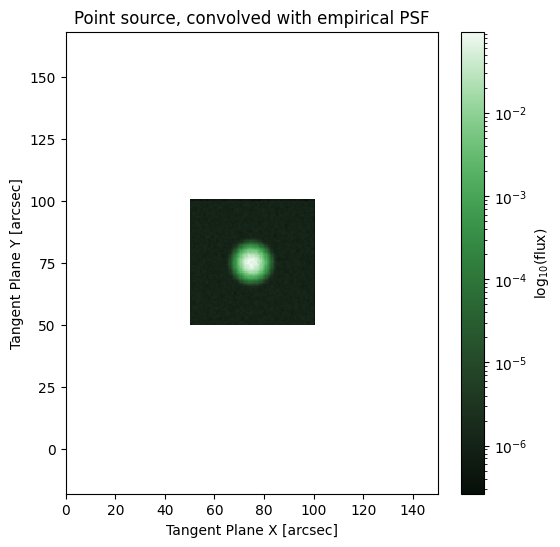

In [3]:
pointsource = ap.models.AstroPhot_Model(
    model_type = "point model",
    target = target,
    parameters = {"center": [75,75], "flux": 1},
    psf = psf_target,
)
pointsource.initialize()
# With a convolved sersic the center is much more smoothed out
fig, ax = plt.subplots(figsize = (6,6))
ap.plots.model_image(fig, ax, pointsource)
ax.set_title("Point source, convolved with empirical PSF")
plt.show()

## Extended model PSF convolution

For extended sources (galaxies mostly), an important part of astronomical image analysis is accounting for PSF effects. To that end, AstroPhot includes a number of approaches to handle PSF convolution. The main concept is that AstroPhot will convolve its model with a PSF before comparing against an image. The PSF behaviour of a model is determined by the `psf_mode` parameter which can be set before fitting.

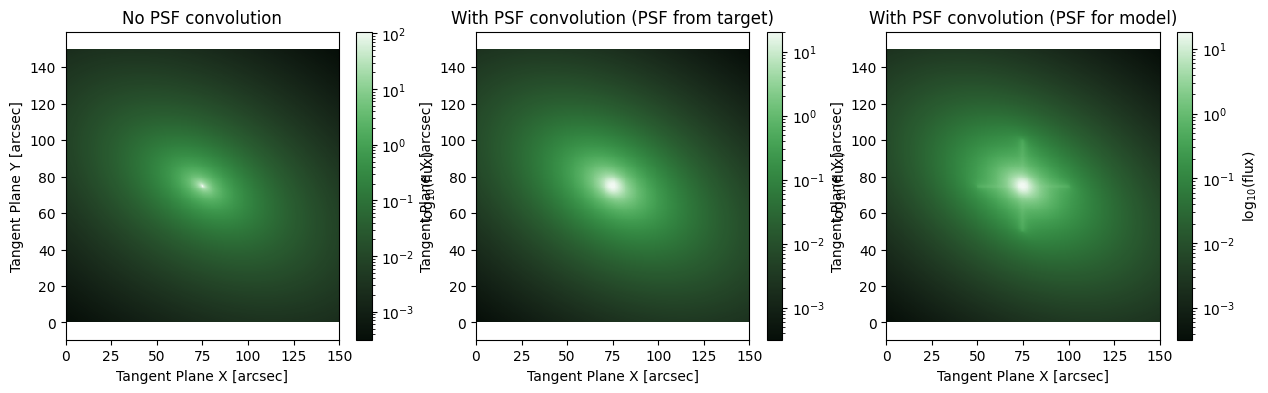

In [4]:
model_nopsf = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [75,75], "q": 0.6, "PA": 60*np.pi/180, "n": 3, "Re": 10, "Ie": 1},
    psf_mode = "none", # no PSF convolution will be done
)
model_nopsf.initialize()
model_psf = ap.models.AstroPhot_Model(
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [75,75], "q": 0.6, "PA": 60*np.pi/180, "n": 3, "Re": 10, "Ie": 1},
    psf_mode = "full", # now the full window will be PSF convolved using the PSF from the target
)
model_psf.initialize()

psf = psf.copy()
psf[49:51] += 4*np.mean(psf)
psf[:,49:51] += 4*np.mean(psf)
psf_target_2 = ap.image.PSF_Image(
    data=psf,
    pixelscale=0.5,
)
psf_target_2.normalize()
model_selfpsf = ap.models.AstroPhot_Model( 
    model_type = "sersic galaxy model",
    target = target,
    parameters = {"center": [75,75], "q": 0.6, "PA": 60*np.pi/180, "n": 3, "Re": 10, "Ie": 1},
    psf_mode = "full", 
    psf = psf_target_2, # Now this model has its own PSF, instead of using the target psf
)
model_selfpsf.initialize()

# With a convolved sersic the center is much more smoothed out
fig, ax = plt.subplots(1,3,figsize = (15,4))
ap.plots.model_image(fig, ax[0], model_nopsf)
ax[0].set_title("No PSF convolution")
ap.plots.model_image(fig, ax[1], model_psf)
ax[1].set_title("With PSF convolution (PSF from target)")
ap.plots.model_image(fig, ax[2], model_selfpsf)
ax[2].set_title("With PSF convolution (PSF for model)")
plt.show()

That covers the basics of adding PSF convolution kernels to AstroPhot models! These techniques assume you already have a model for the PSF that you got with some other algorithm (ie PSFEx), however AstroPhot also has the ability to model the PSF live along with the rest of the models in an image. If you are interested in extracting the PSF from an image using AstroPhot, check out the `AdvancedPSFModels` tutorial. 